## LM_SynEval full dataset
I shifted the embedding procedure to Vector cluster. The tensors (including the PCA model) are saved at `scripts/0804_run_syneval/0804_embedded`

In [1]:
import numpy as np
import os, sys, time
import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from utils import timed_func

In [2]:
embedded_dir = "../scripts/0804_run_syneval/0804_embedded"

@timed_func
def load_data():
    with open(os.path.join(embedded_dir, "pcamodel.pkl"), "rb") as f:
        pca = pickle.load(f)

    all_diff_vecs = {}
    for fname in os.listdir(embedded_dir):
        if fname.startswith("pca"):
            continue
        else:
            with open(os.path.join(embedded_dir, fname), "rb") as f:
                diff_vecs = pickle.load(f)
            name = fname[:-4]  # e.g., "vp_coord"
            all_diff_vecs[name] = diff_vecs
            
    return pca, all_diff_vecs

pca, all_diff_vecs = load_data()

load_data done in 0.10 seconds.


In [3]:
all_diff_vecs.keys()

dict_keys(['long_vp_coord', 'npi_across_anim', 'npi_across_inanim', 'simple_agrmt', 'simple_npi_anim', 'simple_npi_inanim', 'simple_reflexives', 'vp_coord'])

In [4]:
all_diff_vecs['vp_coord'].shape
name = "vp_coord"

Text(0.5, 1.0, 'KDE of PCA of 2-class SynEval sets')

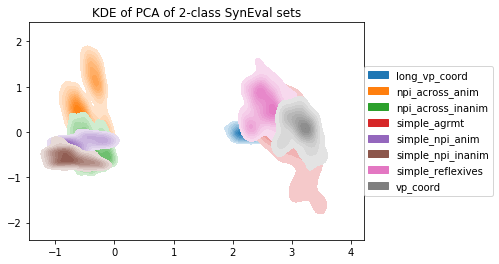

In [5]:
fig = plt.figure()
for name in all_diff_vecs:
    X = all_diff_vecs[name].numpy()
    z = pca.transform(X)
    sns.kdeplot(z[:, 0], z[:, 1], shade=True, shade_lowest=False, label=name)
plt.legend(loc="right", bbox_to_anchor=(1.4, 0.5))
plt.title("KDE of PCA of 2-class SynEval sets")

## Cluster Analysis
In high dimensional space (i.e., no PCA), see how well a k-means alg can cluster the points

In [6]:
def purity_score(y_true, y_pred):
    # https://stackoverflow.com/a/51672699/4012272
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def kmeans_cluster(all_diff_vecs):
    name_indices = [n for n in all_diff_vecs]
    X = []
    Ylabel = []
    for n in all_diff_vecs:
        X.append(all_diff_vecs[n])
        Ylabel.extend([name_indices.index(n)]*len(all_diff_vecs[n]))
        
    X = np.vstack([all_diff_vecs[n] for n in all_diff_vecs])
    kmeans = KMeans(n_clusters=len(all_diff_vecs), random_state=0)
    kmeans.fit(X)
    Ypred = kmeans.predict(X)  # 1-d array
    
    # Measure cluster quality
    purity = purity_score(Ylabel, Ypred)
    print("Purity: {:.4f}".format(purity))
    
kmeans_cluster(all_diff_vecs)

Purity: 0.8097


## Interpretation
Among the categories with two "tenses", there seem to be two large clusters:  
- `npi_across_anim`, `npi_across_inanim`, `simple_npi_anim`, `simple_npi_inanim`. The diff are pointing from "past" to "future" (i.e., two tenses are "past" and "future").  
- `simple_reflexives`, `vp_coord`, `long_vp_coord`, `simple_agrmt`. The two tenses are "singular" and "plural".  

There is evidence of large disentanglements between "time vector" and "number vector", but less disentanglements within each category (purity is low).  

In [7]:
print ("Clustering of these two sets should have very high purity")
set1 = ["npi_across_anim", "npi_across_inanim", "simple_npi_anim", "simple_npi_inanim"]
set2 = ["simple_reflexives", "vp_coord", "long_vp_coord", "simple_agrmt"]
data_2classes = {
    "past2future": np.vstack([all_diff_vecs[n] for n in set1]),
    "sing2plural": np.vstack([all_diff_vecs[n] for n in set2])
}
kmeans_cluster(data_2classes)

print ("Clustering within these two sets should have lower purity")
data_past2future = {}
for n in set1:
    data_past2future[n] = all_diff_vecs[n]
print ("data_past2future:")
kmeans_cluster(data_past2future)
data_sing2plural = {}
for n in set2:
    data_sing2plural[n] = all_diff_vecs[n]
print ("data_sing2plural:")
kmeans_cluster(data_sing2plural)

Clustering of these two sets should have very high purity
Purity: 1.0000
Clustering within these two sets should have lower purity
data_past2future:
Purity: 0.8119
data_sing2plural:
Purity: 0.9157
